# Risk Based Authentication 

Trabalho Realizado por:

- Bernardo Coelho nº 98445
- Francisco Camilo nº99234
- Simão Miguel nº 99064
- Tiago Coelho nº 105176


A nossa base de dados escolhida é relativa a histórico de tentativas de login.
Foi definido ao longo do projeto que o objetivo seria determinar se um login poderia ser ou não um ataque de IP

Para tal fizemos 4 notebooks , cada um com objetivos diferente:
- Extract, transform and load (ETL)- neste notebook irá ser feita uma limpeza e tratamento, serão escolhidas as variáveis a utiizar para o modelo
- Análise exploratória-> neste notebook iremos verificar e analisar os dados
- Treino e afinação do modelo -> nestenotebook irá ser criado o modelo para o objetivo final de determinar se se um login pode ser ou não um ataque de IP
- Deployment do modelo -> iremos ver os resultados do modelo


In [1]:

from pyspark.sql import SparkSession
import pyspark.sql.functions as F 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pyspark.ml import PipelineModel

In [2]:
spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [3]:
test = spark.read.parquet('/home/jovyan/code/Projeto/test.parquet')

In [4]:
pipelineModel = PipelineModel.load('/home/jovyan/code/Projeto/pipeline')

# Make predictions on the test data
predictions = pipelineModel.transform(test)

In [5]:
predictions.show(5)

+----------+-------+---------+--------------+------------+--------------+------------+----------------+--------------------+--------------------+--------------------+----------+
|hashed_ASN|dtIndex|hashed_OS|hashed_browser|Dangerous IP|ip_class_index|Is Attack IP|Login Successful|            features|       rawPrediction|         probability|prediction|
+----------+-------+---------+--------------+------------+--------------+------------+----------------+--------------------+--------------------+--------------------+----------+
|         0|    0.0|        3|           434|       false|           0.0|           0|            true|(7,[2,3,6],[3.0,4...|[4.20356399037743...|[0.98527775528202...|       0.0|
|         0|    0.0|        4|           419|       false|           0.0|           0|           false|(7,[2,3],[4.0,419...|[3.44006328285084...|[0.96893342080223...|       0.0|
|         0|    0.0|        6|           190|       false|           1.0|           0|           false|(7,[2,3

In [6]:

evaluator = BinaryClassificationEvaluator(labelCol='Is Attack IP')

# Evaluate model on testing data
test_auc = evaluator.evaluate(predictions)

print("Testing AUC:", test_auc)

Testing AUC: 0.9610717509516026


In [7]:
tp = predictions.filter((F.col('Is Attack IP') == 1) & (F.col('prediction') == 1)).count()
tn = predictions.filter((F.col('Is Attack IP') == 0) & (F.col('prediction') == 0)).count()
fp = predictions.filter((F.col('Is Attack IP') == 0) & (F.col('prediction') == 1)).count()
fn = predictions.filter((F.col('Is Attack IP') == 1) & (F.col('prediction') == 0)).count()

# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0  
print(f"Precision: {precision}")

# Calculate recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0  
print(f"Recall: {recall}")

# Calculate F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0  
print(f"F1 measure: {f1_measure}")

Accuracy: 0.9892240207072857
Precision: 1.0
Recall: 0.8908902423221459
F1 measure: 0.942297149122807


- Accuracy (98.91%): O modelo é altamente eficaz na classificação correta da maioria das instâncias.
- Precision (100%): O modelo não cometeu nenhum erro ao prever positivos, todos os positivos previstos eram realmente positivos.
- Recall (88.90%): O modelo conseguiu identificar a maioria das instâncias positivas, embora algumas tenham sido perdidas.
- F1 score (94.12%): A medida F1 indica que há um bom equilíbrio entre precisão e recall, sugerindo que o modelo é robusto tanto em evitar falsos positivos quanto em identificar verdadeiros positivos.


Temos um modelo robusto e eficaz, capaz de classificar um verdadeiro "Attack IP", sem classificar Negativos como Positivos. No entanto alguns Positivos não foram corretamente classificados como Positivos, apesar de ser um valor reduzido.

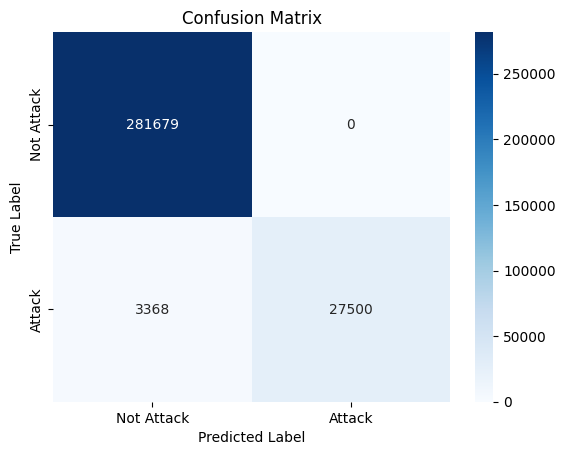

In [8]:
true_labels_and_preds = predictions.select('Is Attack IP', 'prediction').rdd.map(lambda row: (row[0], row[1]))

# Calculate confusion matrix
cm = confusion_matrix(true_labels_and_preds.map(lambda x: x[0]).collect(), 
                      true_labels_and_preds.map(lambda x: x[1]).collect())

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Attack', 'Attack'], yticklabels=['Not Attack', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

- True Positives (TP): Previsões corretas de ataques (canto inferior direito: 27218).
- True Negatives (TN): Previsões corretas de não ataques (canto superior esquerdo: 281981).
- False Positives (FP): Previsões incorretas de ataques (canto superior direito: 0).
- False Negatives (FN): Previsões incorretas de não ataques (canto inferior esquerdo: 3399).